(torch.Size([200]), torch.Size([200]))

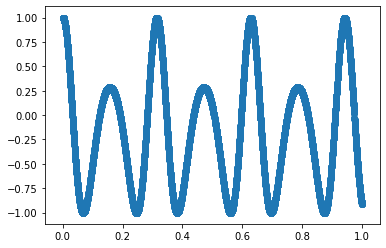

In [11]:
import torch
import matplotlib.pyplot as plt
from fastai2.data.all import *
from fastai2.callback.all import *
from fastai2.learner import Learner
from fastai2.optimizer import SGD

x = torch.rand(10000) 

y = torch.cos(5*torch.sin(10*x))

plt.scatter(x,y)

db = DataBlock(get_x = lambda x:x[0], get_y=lambda x:x[1])

data = torch.stack((x,y),dim=1)
data.shape

dls  =db.dataloaders(data,bs=200, device=torch.device('cpu'))

bx, by = dls.one_batch()

bx.shape, by.shape

In [2]:
def gen_w(steps):
    L = [1.]+[-1.,-1.,1.,1.] * ((steps +3) //4)
    return torch.tensor(L[:steps]) # * steps

class MyModel(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.W1 = torch.nn.Parameter(torch.ones(hidden_size))
        self.W2 = torch.nn.Parameter(gen_w(hidden_size))
        #self.W_scale = torch.nn.Parameter(torch.tensor([float(hidden_size)]))
        self.B1 =  torch.nn.Parameter(-torch.linspace(0,1, hidden_size))
        self.B2 = torch.nn.Parameter(torch.tensor([0.]))
        '''
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, 1)
        '''
    def forward(self, x):
        y1 = F.relu(self.W1 * x[:,None] + self.B1)
        #res = torch.sum(self.W_scale *self.W2 * y1, dim = 1) + self.B2
        res = torch.sum(self.W2 * y1, dim = 1) + self.B2
        #res = self.l2(F.relu(self.l1(x[:,None])))
        return res.squeeze()

In [18]:
class ShowChart(Callback):
    
    def __init__(self, dx, dy, figsize=(10,4)):
        self.figsize = figsize
        self.dx = dx
        self.dy = dy
    def after_validate(self):
    #def after_batch(self):
        self.update_graph()
    
    def update_graph(self):
        if not hasattr(self, 'graph_ax'):
            graph_fig, self.graph_ax = plt.subplots(1, figsize=self.figsize)
            plt.close()
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        model = self.learn.model
        prediction = model(self.dx).detach()
  

        self.graph_ax.clear()
        self.graph_ax.set_ylim(-1.5,1.5)
        self.graph_ax.scatter(self.dx, self.dy, label='actual')
        self.graph_ax.scatter(self.dx,prediction, label = 'pred')
        self.graph_ax.legend(loc='lower left');
        self.graph_out.update(self.graph_ax.figure)
       

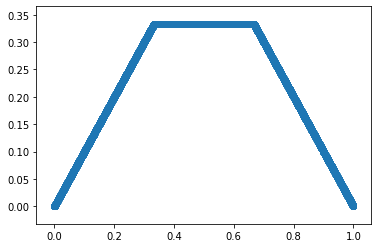

In [73]:
mm = MyModel(4)
learn = Learner(dls,mm, loss_func=nn.MSELoss() , cbs = ShowChart(x,y))

plt.scatter(x, mm(x).detach())

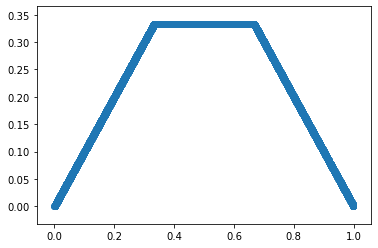

In [27]:
opt = torch.optim.SGD(mm.parameters(), lr=.1)

for epoch in range(40):
    tot_loss = 0
    steps =0
    for bx, by in dls.train:
        res = mm(bx)
        loss = F.mse_loss(res, by)
        loss.backward()
        opt.step()
        opt.zero_grad()
        tot_loss += loss
        steps += 1
    print(epoch, tot_loss / steps)

In [22]:
learn.fit_one_cycle(10, lr_max=1e-2 )

epoch,train_loss,valid_loss,time
0,0.269278,0.247932,00:05
1,0.341437,0.313887,00:05
2,0.309068,0.306547,00:05
3,0.315624,0.287181,00:05
4,0.343980,0.282838,00:05
5,0.330650,0.403414,00:05
6,0.329571,0.429200,00:05
7,0.296959,0.281911,00:05
8,0.282350,0.283250,00:05
9,0.285710,0.282075,00:05


In [4]:
def br(x, c,w, h):
    dist = torch.abs(x-c)
    r = 2 * ( 1 - 2 * dist / w)
    return h * r.clamp(0, 1)



In [5]:
class BarModule(torch.nn.Module):
    def __init__(self, n):
        super().__init__()
        self.c = nn.Parameter(torch.linspace(0,1,n))
        self.h = nn.Parameter(2*torch.rand(n)-1)
        d = 1/(n-1)
        self.w = nn.Parameter(4 * d / 3 * torch.ones(n))
    def forward(self, x):
        res = 0
        res = br(x[:,None],self.c, self.w, self.h)
        return torch.sum(res, dim=1) 

In [45]:
bm = BarModule(10)
learn = Learner(dls,bm, loss_func=nn.MSELoss(), cbs = ShowChart(x,y))

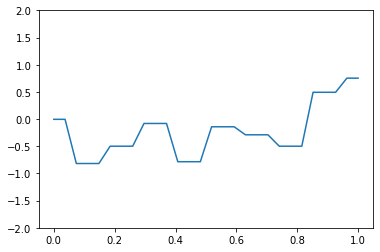

In [46]:
bx = torch.linspace(0,1,1000)
by = bm(bx).detach()
plt.plot(bx, by)
plt.ylim(-2,2)
plt.show()

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=1.5848932266235352)

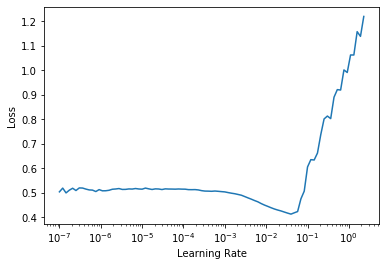

In [44]:
learn.lr_find()

In [50]:
list(zip(bm.c,bm.h))

[(tensor(0.0135, grad_fn=<SelectBackward>),
  tensor(0.6204, grad_fn=<SelectBackward>)),
 (tensor(0.0660, grad_fn=<SelectBackward>),
  tensor(-0.8947, grad_fn=<SelectBackward>)),
 (tensor(0.2420, grad_fn=<SelectBackward>),
  tensor(-0.8714, grad_fn=<SelectBackward>)),
 (tensor(0.3757, grad_fn=<SelectBackward>),
  tensor(-0.2776, grad_fn=<SelectBackward>)),
 (tensor(0.3907, grad_fn=<SelectBackward>),
  tensor(-0.6687, grad_fn=<SelectBackward>)),
 (tensor(0.5555, grad_fn=<SelectBackward>),
  tensor(-0.7667, grad_fn=<SelectBackward>)),
 (tensor(0.7015, grad_fn=<SelectBackward>),
  tensor(-0.8423, grad_fn=<SelectBackward>)),
 (tensor(0.8806, grad_fn=<SelectBackward>),
  tensor(-0.8772, grad_fn=<SelectBackward>)),
 (tensor(0.9365, grad_fn=<SelectBackward>),
  tensor(0.5550, grad_fn=<SelectBackward>)),
 (tensor(0.9277, grad_fn=<SelectBackward>),
  tensor(0.4255, grad_fn=<SelectBackward>))]

epoch,train_loss,valid_loss,time
0,0.375218,0.272586,00:02
1,0.271042,0.198523,00:02
2,0.221402,0.174100,00:01
3,0.194622,0.161499,00:02
4,0.176683,0.152011,00:02
5,0.163427,0.143835,00:02
6,0.153655,0.136300,00:02
7,0.145235,0.129797,00:01
8,0.137458,0.124122,00:01
9,0.127400,0.104548,00:01


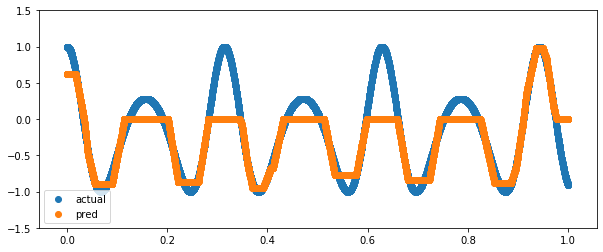

In [47]:
learn.fit(20, lr=1e-3 )